### Analysis of the single nuclear dataset using `poisbeta`'s mle implementation

* This notebook contains sections on:
    1. Import of data
    2. Sorting of nuclei
    3. Inference
    4. Comparison to single cell

In [289]:
import poisbeta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
##### 1. Import of data

In [169]:
count_loc = r"C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myotube_sn_rna_seq\rna_counts.csv"
gene_loc = r"C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myotube_sn_rna_seq\gene_names.csv"

In [170]:
count_df = pd.read_csv(count_loc)
gene_df = pd.read_csv(gene_loc, index_col=0)

In [171]:
d0ctrl = 55
d0fshd = 102
d3ctrl = 178

day_0_control_cols = [col for col in count_df.columns[:d0ctrl]]
day_0_fshd_cols = [col for col in count_df.columns[d0ctrl:d0fshd]]
day_3_control_cols = [col for col in count_df.columns[d0fshd:d3ctrl]]
day_3_fshd_cols = [col for col in count_df.columns[d3ctrl:]]

In [197]:
def create_fshd_dux4_plus_targets_input(df, gene_df, genes):
    
    df.set_index(gene_df['hgnc_symbol'], inplace=True)
    n_df = df[df.index.isin(genes)].copy()
    n_df.drop(df.columns[0], axis=1, inplace=True)
    n_df.columns = [f"Cell{cell_n + 1}" for cell_n in range(n_df.shape[1])]

    return n_df

In [214]:
genes = ["DUX4", "PRAMEF1", "PRAMEF12", "PRAMEF2", "RFPL1", "RFPL2", "RFPL4B", "TRIM43", "ZSCAN4"]
filters = [day_0_control_cols, day_0_fshd_cols, day_3_control_cols, day_3_fshd_cols]

day_disease_dfs = [count_df[filter_] for filter_ in filters]
day_disease_inputs = [create_fshd_dux4_plus_targets_input(df, gene_df, genes) for df in day_disease_dfs]
[df.sort_index(inplace=True) for df in day_disease_inputs]

[None, None, None, None]

In [215]:
cell_n = [len(dataframe.columns) for dataframe in day_disease_inputs]

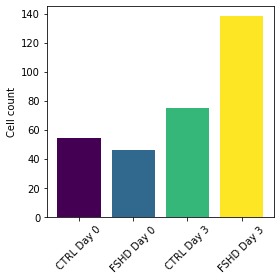

In [227]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

bar_labels = ["CTRL Day 0", "FSHD Day 0", "CTRL Day 3", "FSHD Day 3"]

cmap = plt.colormaps['viridis']
c_list = cmap(np.linspace(0, 1, len(bar_labels)))

ax.bar(x=bar_labels, height=cell_n, color=c_list)
ax.tick_params(axis='x', labelrotation = 45)

ax.set_ylabel("Cell count")

fig.tight_layout()
fig.savefig("cell_type_count.png", dpi=300)

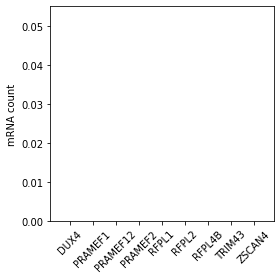

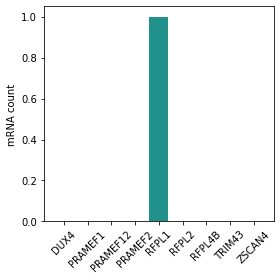

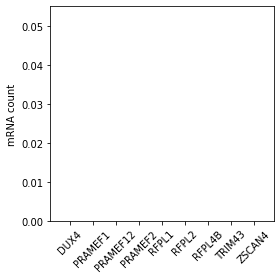

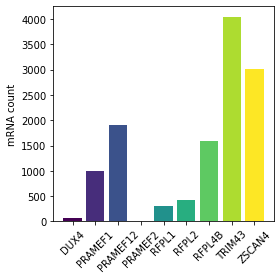

In [307]:
file_labels = ["ctrl_day_0", "fshd_day_0", "ctrl_day_3", "fshd_day_3"]
for index, df in enumerate(day_disease_inputs):
    fig, ax = plt.subplots(figsize=(4, 4))
    c_list = cmap(np.linspace(0, 1, len(genes)))
    ax.bar(genes, df.sum(axis=1), color=c_list)
    ax.tick_params(axis='x', labelrotation = 45)
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel("mRNA count")

    fig.tight_layout()
    fig.savefig(f"{file_labels[index]}_gene_rna_count.png", dpi=300)

---
##### 2. Sorting of nuclei type:

In [233]:
def sort_by_dux4_and_target(df):
    # DUX4 containing cells
    dux4_cols = [col for col in df.columns if df[col]["DUX4"] != 0]
    dux4_df = df[dux4_cols].copy()

    # DUX4 and target containing cells
    targ_df = dux4_df.drop(index="DUX4")
    dux4_targ_cols = [col for col in targ_df if targ_df[col].max() != 0]
    dux4_pos_targ_pos = targ_df[dux4_targ_cols]

    # DUX4 cells with no target
    dux4_no_targ_cols = [col for col in targ_df if targ_df[col].max() == 0]
    dux4_pos_targ_neg = targ_df[dux4_no_targ_cols]

    # Non-DUX4 containing cells
    neg_cols = [col for col in df.columns if df[col]["DUX4"] == 0]
    neg_df = df[neg_cols].copy()

    # Non-DUX4 cells with targets
    neg_targ_cols = [col for col in neg_df if neg_df[col].max() != 0]
    dux4_neg_targ_pos = neg_df[neg_targ_cols]

    # Non-DUX4 cells with no targets
    neg_no_targ_cols = [col for col in neg_df if neg_df[col].max() == 0]
    dux4_neg_targ_neg = neg_df[neg_no_targ_cols]

    return dux4_neg_targ_neg, dux4_pos_targ_neg, dux4_pos_targ_pos, dux4_neg_targ_pos

In [234]:
dux4_neg_targ_neg, dux4_pos_targ_neg, dux4_pos_targ_pos, dux4_neg_targ_pos = sort_by_dux4_and_target(day_disease_inputs[-1])

In [235]:
data_list = [dux4_neg_targ_neg, dux4_pos_targ_neg, dux4_pos_targ_pos, dux4_neg_targ_pos]
cell_n = [len(dataframe.columns) for dataframe in data_list]

In [241]:
# print("dux4_targ/dux4_no_targ:", cell_n[2] / cell_n[1])
print("neg_targ/neg_no_targ:", cell_n[3] / cell_n[0])

neg_targ/neg_no_targ: 1.3275862068965518


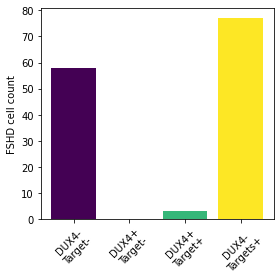

In [240]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

bar_labels = ["DUX4-\nTarget-", "DUX4+\nTarget-", "DUX4+\nTarget+", "DUX4-\nTargets+",]

cmap = plt.colormaps['viridis']
c_list = cmap(np.linspace(0, 1, len(bar_labels)))

ax.bar(x=bar_labels, height=cell_n, color=c_list)
ax.tick_params(axis='x', labelrotation = 45)

# ax.set_yscale('log')

ax.set_ylabel("FSHD cell count")

fig.tight_layout()
fig.savefig("fshd_cell_class_count.png", dpi=300)

In [242]:
def cell_target_sum(df):
    return [df[col].sum() for col in df]

def cell_target_unique(df):
    return [len(df[col].to_numpy().nonzero()[0]) for col in df]

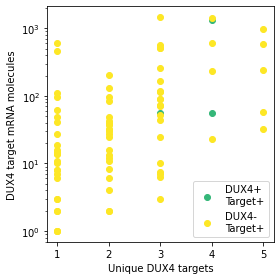

In [266]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

data_list = [dux4_pos_targ_pos, dux4_neg_targ_pos]
data_labels = ["DUX4+\nTarget+", "DUX4-\nTarget+"]

for index, data in enumerate(data_list):

    unique = cell_target_unique(data)
    sum = cell_target_sum(data)

    ax.scatter(unique, sum, color=c_list[index+2], label=data_labels[index])

ax.set_ylabel("DUX4 target mRNA molecules")
ax.set_xlabel("Unique DUX4 targets")

ax.set_yscale("log")

ax.legend()

fig.tight_layout()
fig.savefig(f"target_unique_sum_plot.png", dpi=300)

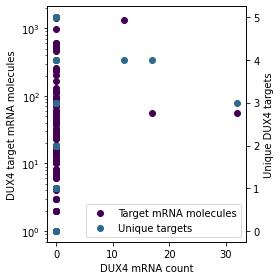

In [287]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

ax2 = ax.twinx()

fshd_day_3_targ_sum = cell_target_sum(day_disease_inputs[-1].iloc[1:])
fshd_day_3_targ_unique = cell_target_unique(day_disease_inputs[-1].iloc[1:])
fshd_day_3_dux4_sum = day_disease_inputs[-1].iloc[0].values

ax.scatter(fshd_day_3_dux4_sum, fshd_day_3_targ_sum, color=c_list[0])
ax2.scatter(fshd_day_3_dux4_sum, fshd_day_3_targ_unique, color=c_list[1])

ax.set_ylabel("DUX4 target mRNA molecules")
ax2.set_ylabel("Unique DUX4 targets")
ax.set_xlabel("DUX4 mRNA count")

ax.set_yscale("log")

ax.scatter(0, 0, color=c_list[1])
ax.legend(["Target mRNA molecules", "Unique targets"],
            )

fig.tight_layout()


---
##### 3. Inference:

In [290]:
def pb_inference(df, genes):
    theta_array = np.zeros((len(genes), 3))

    for index, gene in enumerate(genes):
        data = df.loc[gene].to_numpy('int32')

        if max(data) == 0:
            print(f"{genes[index]} gene has no transcripts.")
            
        else:
            try:
                theta = np.exp(poisbeta.fit_poisson_beta_mle(data))
                theta_array[index] = theta

            except:
                print(f"Inference failed for {genes[index]} gene")
                
                try:
                    init = np.log([1e-3, 1, 1])
                    print(init)
                    theta = np.exp(poisbeta.fit_poisson_beta_mle(data, init=init))
                    theta_array[index] = theta
                
                except:
                    print(f"Inference with init failed for {genes[index]} gene")
    
    return theta_array

In [291]:
fshd_day_3_params = pb_inference(day_disease_inputs[-1], genes)

PRAMEF2 gene has no transcripts.


C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\_optimize.py:811: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Inference failed for TRIM43 gene
[-6.90775528  0.          0.        ]
Inference with init failed for TRIM43 gene


In [292]:
fshd_day_3_params

array([[2.95440798e+01, 2.55281041e-03, 1.99586907e-01],
       [4.08146851e+02, 2.68332143e-02, 1.37210910e+00],
       [1.39492465e+03, 3.33756060e-02, 2.88594306e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.72756060e+02, 1.05459761e-02, 6.94597069e-01],
       [1.75316256e+02, 2.21811108e-02, 1.13872163e+00],
       [1.73790702e+03, 3.70354212e-02, 4.18679987e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.91548325e+02, 5.95527861e-02, 2.00297240e+00]])

In [297]:
def params_plot(mle_thetas, label=None):
    scale = 4
    fig, ax = plt.subplots(figsize=(scale, scale))

    cmap = plt.colormaps['viridis']
    c_list = cmap(np.linspace(0, 1, mle_thetas.shape[0]))

    for index, gene in enumerate(genes):
        k0_k1 = mle_thetas[index, 1] / mle_thetas[index, 2]
        ax.scatter(k0_k1, mle_thetas[index, 0], color=c_list[index])

    for index, gene in enumerate(genes):
        ax.scatter(0, 0, color=c_list[index], label=f"{gene}")

    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylabel("$v_0$")
    ax.set_xlabel("$k_0/k_1$")

    ax.set_ylim(1e0, 1e6)
    ax.set_xlim(1e-6, 2e0)

    fig.tight_layout()
    fig.savefig(f"mle_{label}_dux4_targets_fshd_patients.png", dpi=500)

C:\Users\mvc28\AppData\Local\Temp\ipykernel_11904\1224780653.py:9: RuntimeWarning: invalid value encountered in double_scalars
  k0_k1 = mle_thetas[index, 1] / mle_thetas[index, 2]


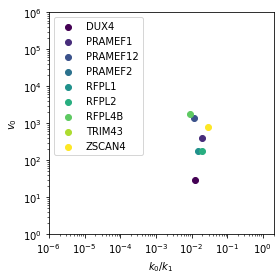

In [298]:
params_plot(fshd_day_3_params, "fshd_day3")

In [309]:
pd.DataFrame(fshd_day_3_params, index=genes, columns=["v0", "k0", "k1"]).to_csv(f"fshd_day_3_params.csv")

---
##### 4. Comparison to single cell data:

In [ ]:
sc_data = pd.read_csv(r"C:\Users\mvc28\OneDrive - University of Bath\lab-books\y3\kings_fshd\poisbeta\indv_patients\dux4_target_genes\dux4_targets_by_disease\fshd_dux4_cells\fshd_cell_class_params\all_fshd_cells_params.csv", index_col=0)
sn_data = pd.read_csv(r"C:\Users\mvc28\OneDrive - University of Bath\lab-books\y3\kings_fshd\sn_rna_seq\fshd_day_3_params.csv", index_col=0)

sc_dux4_pos_data = pd.read_csv(r"C:\Users\mvc28\OneDrive - University of Bath\lab-books\y3\kings_fshd\poisbeta\indv_patients\dux4_target_genes\dux4_targets_by_disease\fshd_dux4_cells\dux4_pos_and_neg_params\fshd_cells_dux4_pos_params.csv", index_col=0)
sc_dux4_neg_data = pd.read_csv(r"C:\Users\mvc28\OneDrive - University of Bath\lab-books\y3\kings_fshd\poisbeta\indv_patients\dux4_target_genes\dux4_targets_by_disease\fshd_dux4_cells\dux4_pos_and_neg_params\fshd_cells_dux4_neg_params.csv", index_col=0)
sc_dux4_pos_targ_pos_data = pd.read_csv(r"C:\Users\mvc28\OneDrive - University of Bath\lab-books\y3\kings_fshd\poisbeta\indv_patients\dux4_target_genes\dux4_targets_by_disease\fshd_dux4_cells\fshd_cell_class_params\fshd_cells_dux4_pos_targ_pos_params.csv", index_col=0)
sc_dux4_neg_targ_pos_data = pd.read_csv(r"C:\Users\mvc28\OneDrive - University of Bath\lab-books\y3\kings_fshd\poisbeta\indv_patients\dux4_target_genes\dux4_targets_by_disease\fshd_dux4_cells\fshd_cell_class_params\fshd_cells_dux4_neg_targ_pos_params.csv", index_col=0)

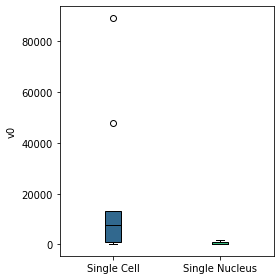

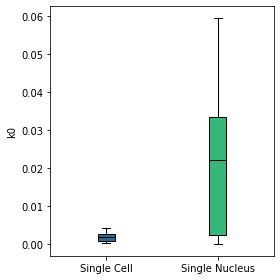

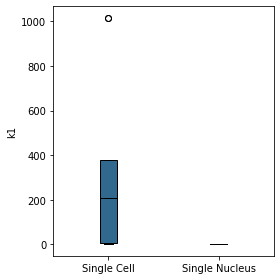

In [ ]:
for col in sc_data.columns:
    scale = 4
    fig, ax = plt.subplots(figsize=(scale, scale))

    cmap = plt.colormaps['viridis']
    c_list = cmap(np.linspace(0, 1, 4))

    box = ax.boxplot([sc_data[col], sn_data[col]],
                labels=["Single Cell", "Single Nucleus"], patch_artist=True)

    colors = [c_list[1], c_list[2]]
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    for median in box['medians']:
        median.set_color('black')

    ax.set_ylabel(f"{col}")

    fig.tight_layout()

    fig.savefig(f"sc_sn_{col}_comparison.png", dpi=300)

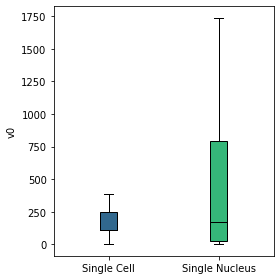

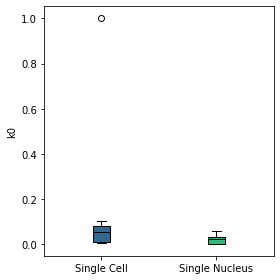

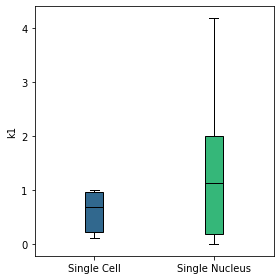

In [ ]:
for col in sc_data.columns:
    scale = 4
    fig, ax = plt.subplots(figsize=(scale, scale))

    cmap = plt.colormaps['viridis']
    c_list = cmap(np.linspace(0, 1, 4))

    box = ax.boxplot([sc_dux4_pos_data[col], sn_data[col]],
                labels=["Single Cell", "Single Nucleus"], patch_artist=True)

    colors = [c_list[1], c_list[2]]
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    for median in box['medians']:
        median.set_color('black')

    ax.set_ylabel(f"{col}")

    fig.tight_layout()

    fig.savefig(f"sc_dux4_pos_sn_{col}_comparison.png", dpi=300)

In [ ]:
p_sc_sn = st.wilcoxon(sc_data, sn_data).pvalue
p_sc_dux4_pos_sn = st.wilcoxon(sc_dux4_pos_data, sn_data).pvalue

In [ ]:
sc_list = [sc_data, sc_dux4_pos_data, sc_dux4_neg_data, sc_dux4_pos_targ_pos_data, sc_dux4_neg_targ_pos_data]
sc_p = [st.wilcoxon(sc, sn_data).pvalue for sc in sc_list]

In [ ]:
p_df = pd.DataFrame(sc_p, columns=["v0", "k0", "k1"], index=["SC vs SN", "SC DUX4+ vs SN",
                                                                "SC DUX4- vs SN", "SC DUX4+ Target+ vs SN",
                                                                "SC DUX4- Target+ vs SN"])